In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

import wrangle as w

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

spark = pyspark.sql.SparkSession.builder.getOrCreate()

plt.style.use("ggplot")

# acquire data

In [2]:
case_df = spark.read.csv("case.csv", header=True, inferSchema=True)
dept_df = spark.read.csv("dept.csv", header=True, inferSchema=True)
source_df = spark.read.csv("source.csv", header=True, inferSchema=True)



def wrangle_311(case_df, dept_df, source_df):
    df = case_df.join(source_df, on=case_df.source_id == source_df.source_id, how = 'left').drop(source_df.source_id)
    df = df.join(dept_df, on=df.dept_division == dept_df.dept_division, how = 'left').drop(dept_df.dept_division)
    return df

In [3]:
df = wrangle_311(case_df, dept_df, source_df)

In [4]:
df.show(1, False, True)

-RECORD 0------------------------------------------------------
 case_id                | 1014127332                           
 case_opened_date       | 1/1/18 0:42                          
 case_closed_date       | 1/1/18 12:29                         
 SLA_due_date           | 9/26/20 0:42                         
 case_late              | NO                                   
 num_days_late          | -998.5087616000001                   
 case_closed            | YES                                  
 dept_division          | Field Operations                     
 service_request_type   | Stray Animal                         
 SLA_days               | 999.0                                
 case_status            | Closed                               
 source_id              | svcCRMLS                             
 request_address        | 2315  EL PASO ST, San Antonio, 78207 
 council_district       | 5                                    
 source_username        | svcCRMLS      

In [6]:
df = w.wrangle_311(spark)

[wrangle.py] reading case.csv
[wrangle.py] handling data types
[wrangle.py] parsing dates
[wrangle.py] adding features
[wrangle.py] joining departments


In [7]:
df.show(1, False, True)

-RECORD 0----------------------------------------------------
 case_id              | 1014127332                           
 case_opened_date     | 2018-01-01 00:42:00                  
 case_closed_date     | 2018-01-01 12:29:00                  
 case_due_date        | 2020-09-26 00:42:00                  
 case_late            | false                                
 num_days_late        | -998.5087616000001                   
 case_closed          | true                                 
 service_request_type | Stray Animal                         
 SLA_days             | 999.0                                
 case_status          | Closed                               
 source_id            | svcCRMLS                             
 request_address      | 2315  EL PASO ST, San Antonio, 78207 
 council_district     | 005                                  
 num_weeks_late       | -142.6441088                         
 zipcode              | 78207                                
 case_ag

Answer the questions below by using a combination of the techniques discussed in the lesson that you think is appropriate.

-How many different cases are there, by department?

-Does the percentage of cases that are late vary by department?

-On average, how late are the late cases by department?

-What is the service type that is the most late? Just for Parks & Rec?

-For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

-Does whether or not its a weekend matter for when a case is opened/closed?

-On average, how many cases are opened a day for the Customer Service department?

-Does the number of service requests for the solid waste department vary by day of the week?

In [8]:
# How many different cases are there, by department?
df.groupby('department').count().show()

+--------------------+------+
|          department| count|
+--------------------+------+
|         Solid Waste|279270|
|Animal Care Services|116915|
|Trans & Cap Impro...| 96193|
|  Parks & Recreation| 19907|
|    Customer Service|  2849|
|        Metro Health|  5163|
|        City Council|    33|
|DSD/Code Enforcement|321374|
+--------------------+------+



Text(0.5, 0, 'Number of Cases')

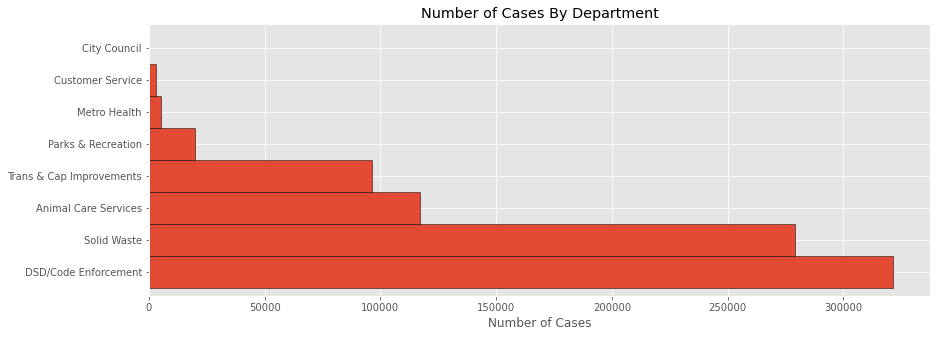

In [9]:
# First aggregate with spark
(
# group by    
    df.groupBy("department")
# aggregate by count    
    .count()
# then pass to pandas
    .toPandas()
# once its a dataframe, pass department as our index
    .set_index("department")["count"]
# sort our values for cleanliness of visualization
    .sort_values(ascending=False)
# pass our Series (department count values) to matplotlib
    .plot.barh(width=1, edgecolor="black", figsize=(14, 5))
)

plt.title("Number of Cases By Department")
plt.ylabel("")
plt.xlabel("Number of Cases")

Text(0.5, 1.0, '% of Late Cases By Department')

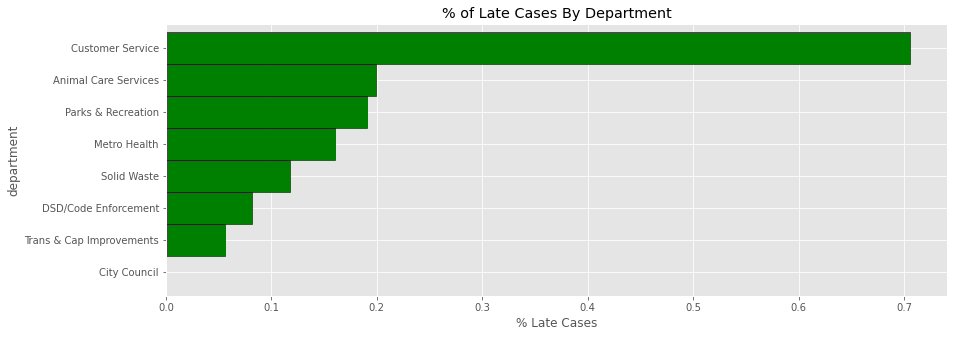

In [10]:
(
    df.withColumn("case_late", col("case_late").cast("int"))
    .groupby("department")
    .agg(avg("case_late").alias("prob_cases_late"))
    .toPandas()
    .set_index("department")
    .prob_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("% Late Cases")
plt.title("% of Late Cases By Department")

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

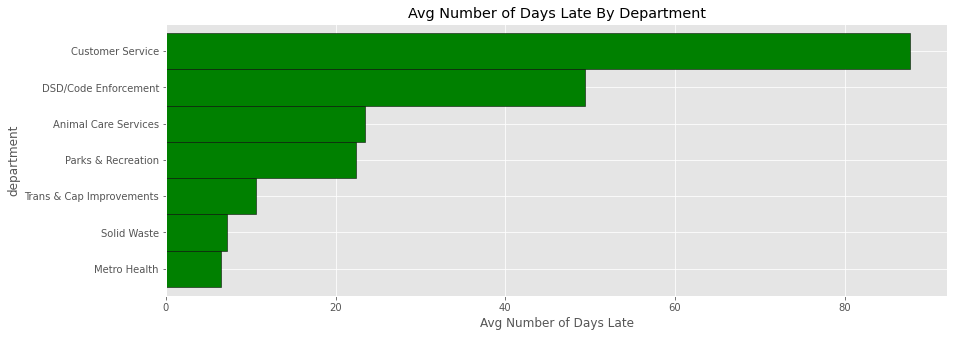

In [11]:
(
    df.where('case_late')
    .groupby("department")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .toPandas()
    .set_index("department")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

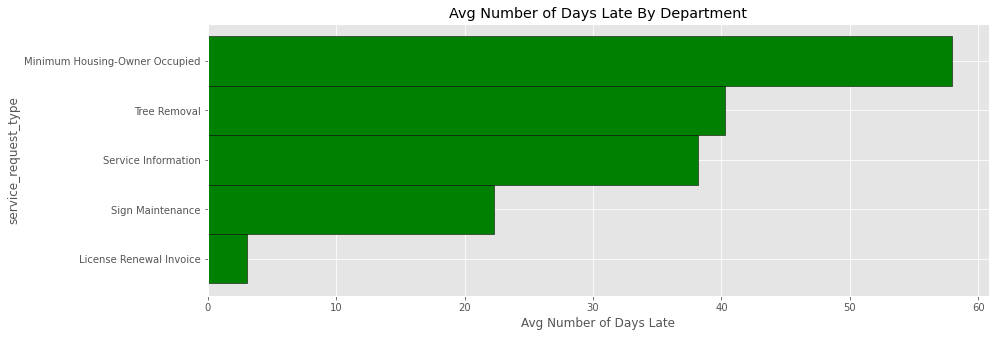

In [12]:
(
    df.where('case_late')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

Text(0.5, 1.0, 'Avg Number of Days Late By Department')

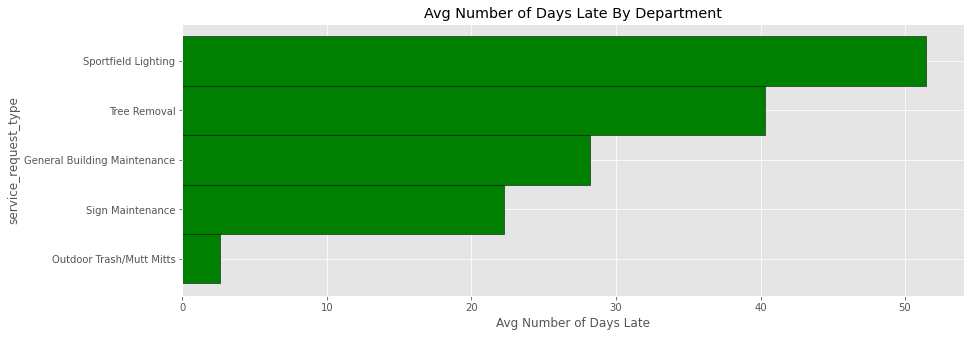

In [13]:
(
    df.where('case_late').where(df.department=='Parks & Recreation')
    .groupby("service_request_type")
    .agg(avg("num_days_late").alias("days_cases_late"))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .days_cases_late.sort_values()
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)
plt.xlabel("Avg Number of Days Late")
plt.title("Avg Number of Days Late By Department")

Text(0.5, 1.0, 'Requests in DSD/Code Enforcement')

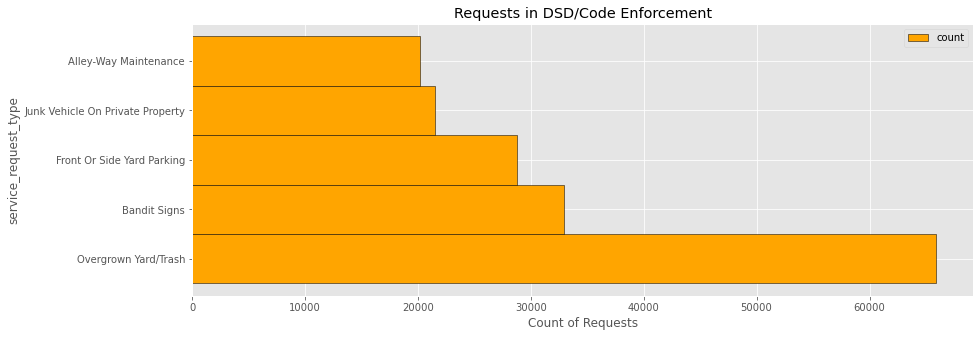

In [14]:
(
    df.where(expr('department=="DSD/Code Enforcement"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in DSD/Code Enforcement")

Text(0.5, 1.0, 'Requests in Parks & Recreation')

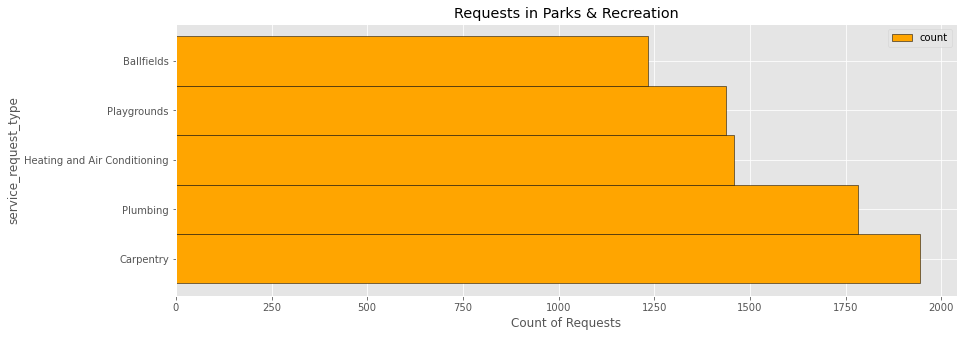

In [15]:
(
    df.where(expr('department=="Parks & Recreation"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in Parks & Recreation")

Text(0.5, 1.0, 'Requests in Animal Care Services')

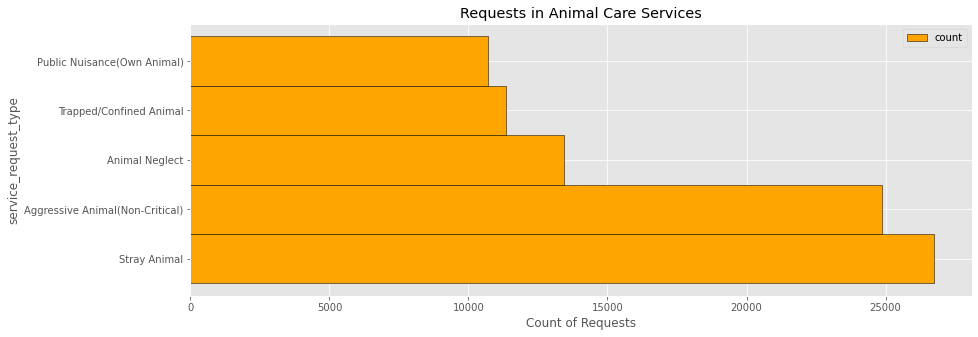

In [16]:
(
    df.where(expr('department=="Animal Care Services"'))
    .groupby("service_request_type")
    .count()
    .sort(desc('count'))
    .limit(5)
    .toPandas()
    .set_index("service_request_type")
    .plot.barh(width=1, edgecolor="black", color='orange', figsize=(14, 5))
)
plt.xlabel("Count of Requests")
plt.title("Requests in Animal Care Services")

In [17]:
df = df.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [18]:
df.show(1, vertical=True)

-RECORD 0------------------------------------
 case_id              | 1014127332           
 case_opened_date     | 2018-01-01 00:42:00  
 case_closed_date     | 2018-01-01 12:29:00  
 case_due_date        | 2020-09-26 00:42:00  
 case_late            | false                
 num_days_late        | -998.5087616000001   
 case_closed          | true                 
 service_request_type | Stray Animal         
 SLA_days             | 999.0                
 case_status          | Closed               
 source_id            | svcCRMLS             
 request_address      | 2315  EL PASO ST,... 
 council_district     | 005                  
 num_weeks_late       | -142.6441088         
 zipcode              | 78207                
 case_age             | 219                  
 days_to_closed       | 0                    
 case_lifetime        | 0                    
 department           | Animal Care Services 
 dept_subject_to_SLA  | true                 
 week_day_name        | Mon       

Text(0.5, 1.0, 'Cases Opened by Weekday')

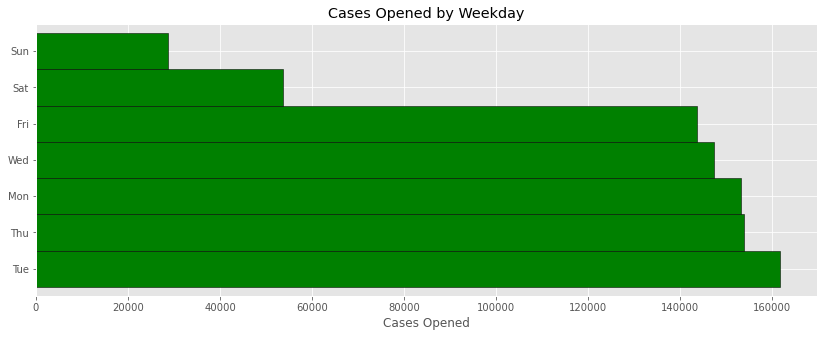

In [19]:
#cases opened
(
    df.groupBy("week_day_name")
    .count()
    .sort(desc('count'))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("week_day_name")["count"]
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.xlabel("Cases Opened")
plt.ylabel("")
plt.title("Cases Opened by Weekday")

In [20]:
#case closed
df = df.withColumn("week_day_name_closed", date_format("case_closed_date", "E"))

Text(0.5, 1.0, 'Cases Closed by Weekday')

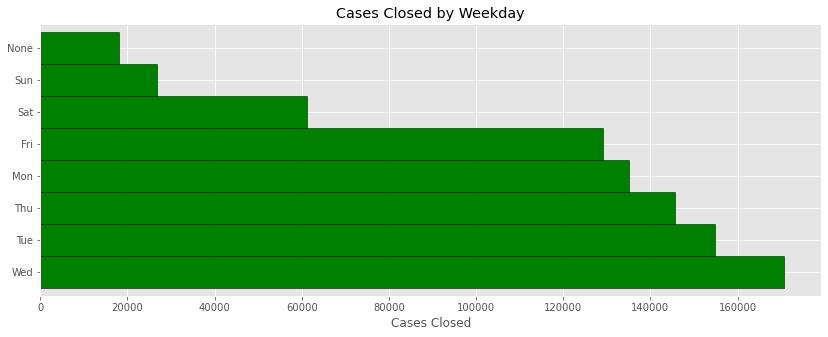

In [21]:
#day of the week case was closed
(
    df.groupBy("week_day_name_closed")
    .count()
    .sort(desc('count'))
    # then pass the data to pandas for visualization
    .toPandas()
    .set_index("week_day_name_closed")["count"]
    .plot.barh(width=1, edgecolor="black", color='green', figsize=(14, 5))
)

plt.xlabel("Cases Closed")
plt.ylabel("")
plt.title("Cases Closed by Weekday")

In [22]:
n_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Customer Service")
    .groupby("case_opened_date")
    .count()
    .toPandas()
)

In [23]:
n_cases

,case_opened_date,count
0,2018-03-17,2
1,2018-01-23,9
2,2018-02-26,4
3,2018-01-11,8
4,2018-01-08,1
...,...,...
507,2017-11-24,2
508,2017-12-27,6
509,2017-10-25,6
510,2017-11-27,9


In [24]:
#5.56 cases opened on average
n_cases.mean()

count    5.564453
dtype: float64

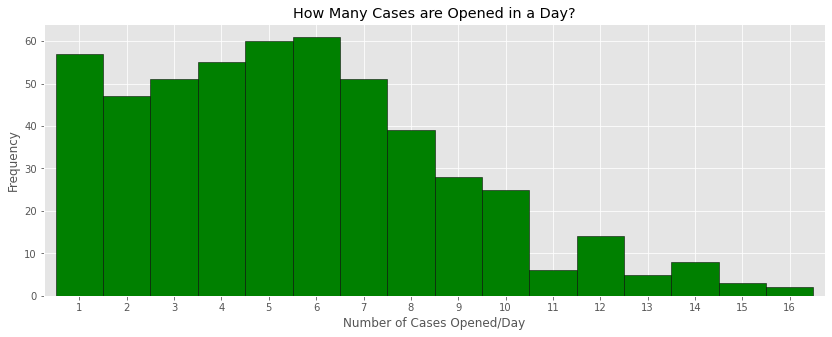

In [25]:
n_of_cases = n_cases['count']
mean_cases = n_of_cases.mean()
n_of_cases.value_counts().sort_index().plot.bar(width=1, edgecolor="black", color='green', figsize=(14, 5))
plt.xlabel("Number of Cases Opened/Day")
plt.ylabel("Frequency")
plt.title("How Many Cases are Opened in a Day?")
plt.xticks(rotation=0)
plt.show()

In [32]:
n_cases = (
    df.withColumn("case_opened_date", expr("date(case_opened_date)"))
    .filter(df.department == "Solid Waste")
    .groupby('case_opened_date')
    .count()
    #.toPandas()
)

In [33]:
n_cases = n_cases.withColumn("week_day_name", date_format("case_opened_date", "E"))

In [34]:
n_cases = n_cases.toPandas().set_index('week_day_name')

In [35]:
n_cases

,case_opened_date,count
week_day_name,,
Sat,2018-03-17,213
Tue,2018-01-23,574
Mon,2018-02-26,735
Thu,2018-01-11,538
Mon,2018-01-08,696
...,...,...
Wed,2017-12-27,391
Thu,2017-11-23,22
Wed,2017-10-25,373


In [36]:
n_cases = n_cases.drop(columns=['case_opened_date'])

In [37]:
n_cases = n_cases.groupby(['week_day_name']).mean()

In [38]:
n_cases

,count
week_day_name,
Fri,616.903614
Mon,691.488095
Sat,184.481928
Sun,81.964286
Thu,574.915663
Tue,691.904762
Wed,499.369048


<AxesSubplot:xlabel='week_day_name'>

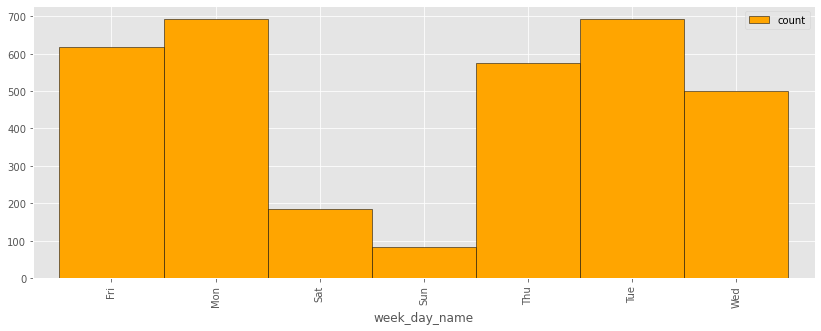

In [39]:
n_cases.plot.bar(width=1, edgecolor="black", color='orange', figsize=(14, 5))

In [40]:
days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#days_type = pd.Categorical(n_cases['week_day_name'],categories=days, ordered=True)

#n_cases['week_day_name'] = n_cases['week_day_name'].astype('category')

In [41]:
n_cases = n_cases.reset_index()

In [42]:
n_cases.loc[n_cases['week_day_name']=='Mon', 'order']=1
n_cases.loc[n_cases['week_day_name']=='Tue', 'order']=2
n_cases.loc[n_cases['week_day_name']=='Wed', 'order']=3
n_cases.loc[n_cases['week_day_name']=='Thu', 'order']=4
n_cases.loc[n_cases['week_day_name']=='Fri', 'order']=5
n_cases.loc[n_cases['week_day_name']=='Sat', 'order']=6
n_cases.loc[n_cases['week_day_name']=='Sun', 'order']=7

In [43]:
n_cases

,week_day_name,count,order
0,Fri,616.903614,5.0
1,Mon,691.488095,1.0
2,Sat,184.481928,6.0
3,Sun,81.964286,7.0
4,Thu,574.915663,4.0
5,Tue,691.904762,2.0
6,Wed,499.369048,3.0


In [44]:
n_cases = n_cases.sort_values('order')

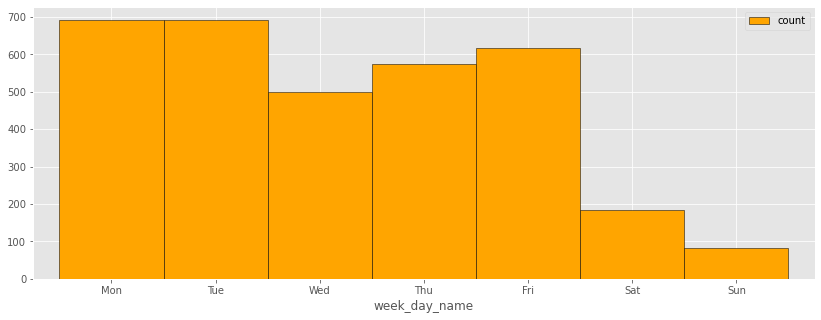

In [45]:
n_cases.plot.bar(x = 'week_day_name', y='count',width=1, edgecolor="black", color='orange', figsize=(14, 5))
plt.xticks(rotation=0)
plt.show()